In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import shutil
import random

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )
    
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [2]:
curr_wv = np.arange(100, 3600, 10)
set_n_comp = 200
set_skip_factor = None
gpSplit = 0.5
N = 10
emulator_typ = "start"

seed = 3
random.seed(seed)
np.random.RandomState(seed)

RandomState(MT19937) at 0x7FF627E20240

In [3]:
reference = pd.read_csv("Classes/reference.csv")
data = reference.sample(N)
iobs_ = np.random.choice(np.arange(0,11,1), size = N, replace = True)
i = 0
for index, row, in tqdm(data.iterrows(), total=N):
    viewing_angle = iobs_[i]
    mejdyn = row.mejdyn
    mejwind =  row.mejwind
    phi = row.phi
    iobs = viewing_angle
    gp = GP5D("Classes/reference.csv")
    gp.split = gpSplit
    gp.emulator = emulator_typ
    gp.cross_validation = (mejdyn, mejwind, phi, iobs)
    gp.set_wv_range(curr_wv)
    gp.n_comp = set_n_comp
    time_shape = None
    gp.save_pca_components(skip_factor = set_skip_factor)
    gp.setXY_cross_validation(mejdyn, mejwind, phi, iobs, messages = False)
    fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 10, lengthscale=10, ARD = True)
    decay_kernel = GPy.kern.Linear(input_dim=4, ARD = True)
    gp.kernel = fitting_kernel * decay_kernel
    gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
    gp.model.optimize(messages = False)
    gp.model_predict_cross_validation(include_like = True, messages = False) # Save cross validation
    gp.model_predict(include_like = True, messages = False)
    gp.save_trained_data()
    
    i += 1
    gp.delete_folder_files("data/pcaComponents")
    gp.delete_folder_files("data/pcaComponentsTrained")
    gp.delete_folder_files("data/transformComponents")
    gp.delete_folder_files("data/pcaComponentsTrainedError")

 90%|█████████ | 9/10 [07:22<00:44, 44.79s/it] /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
100%|██████████| 10/10 [08:25<00:00, 50.54s/it]


100%|██████████| 196/196 [00:01<00:00, 161.69it/s]


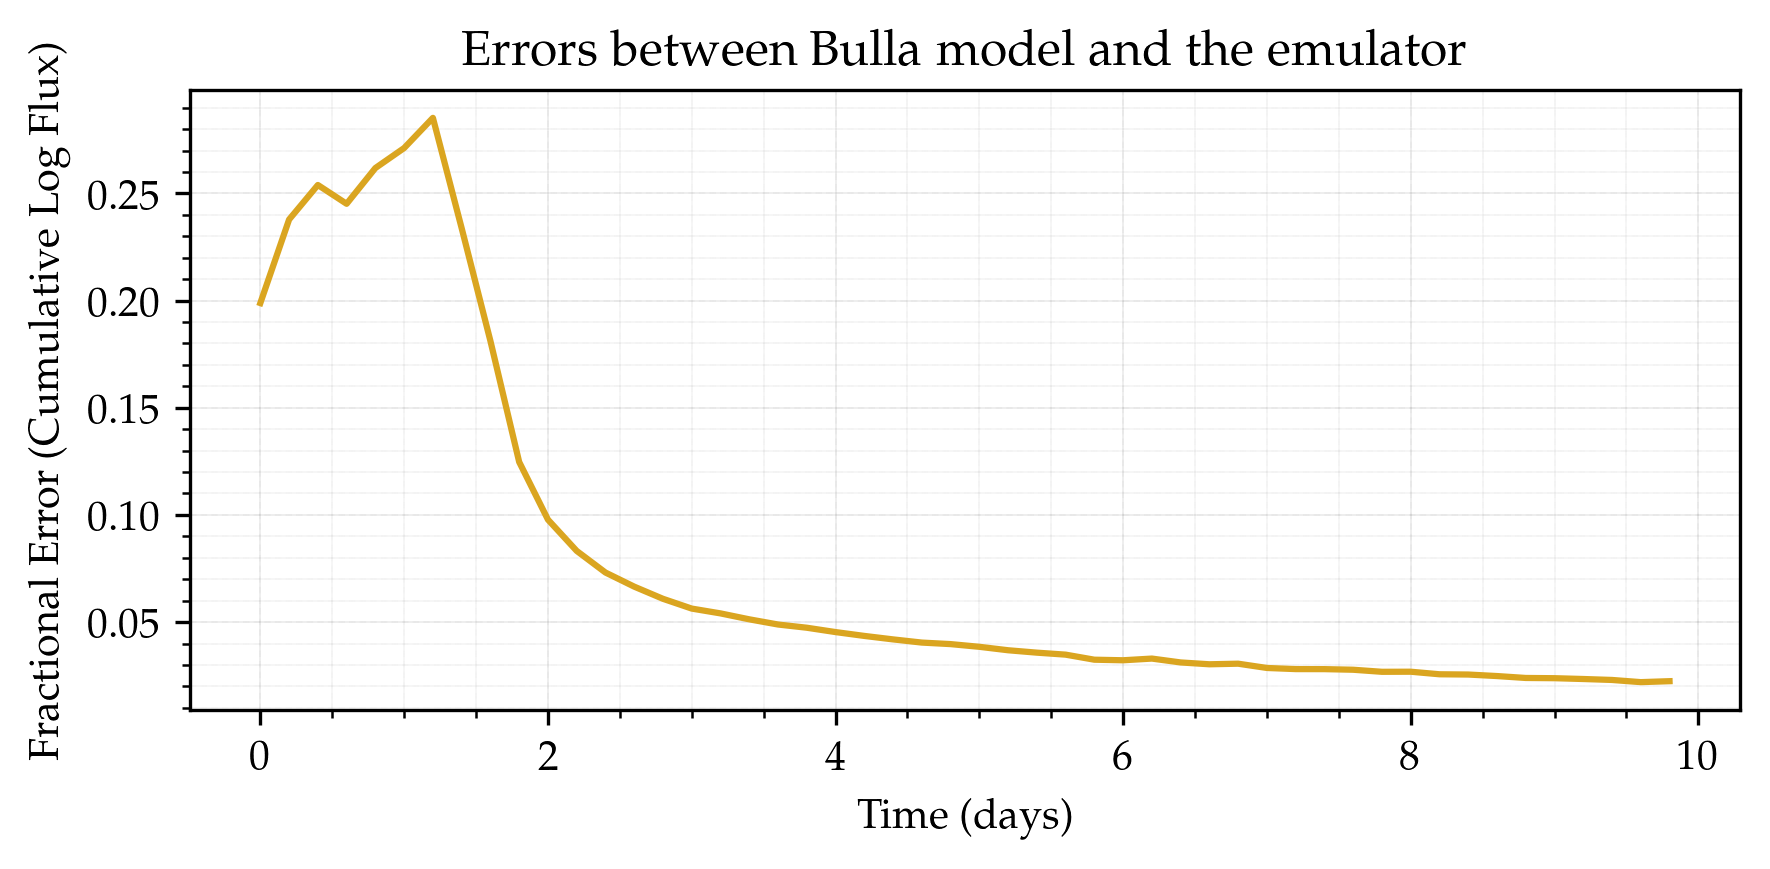

In [4]:
gp.plot_emulator_errors()

Inside 3x: 174764, Total: 175000
[STATUS] Difference histogram for Leave-One-Out Cross Validation


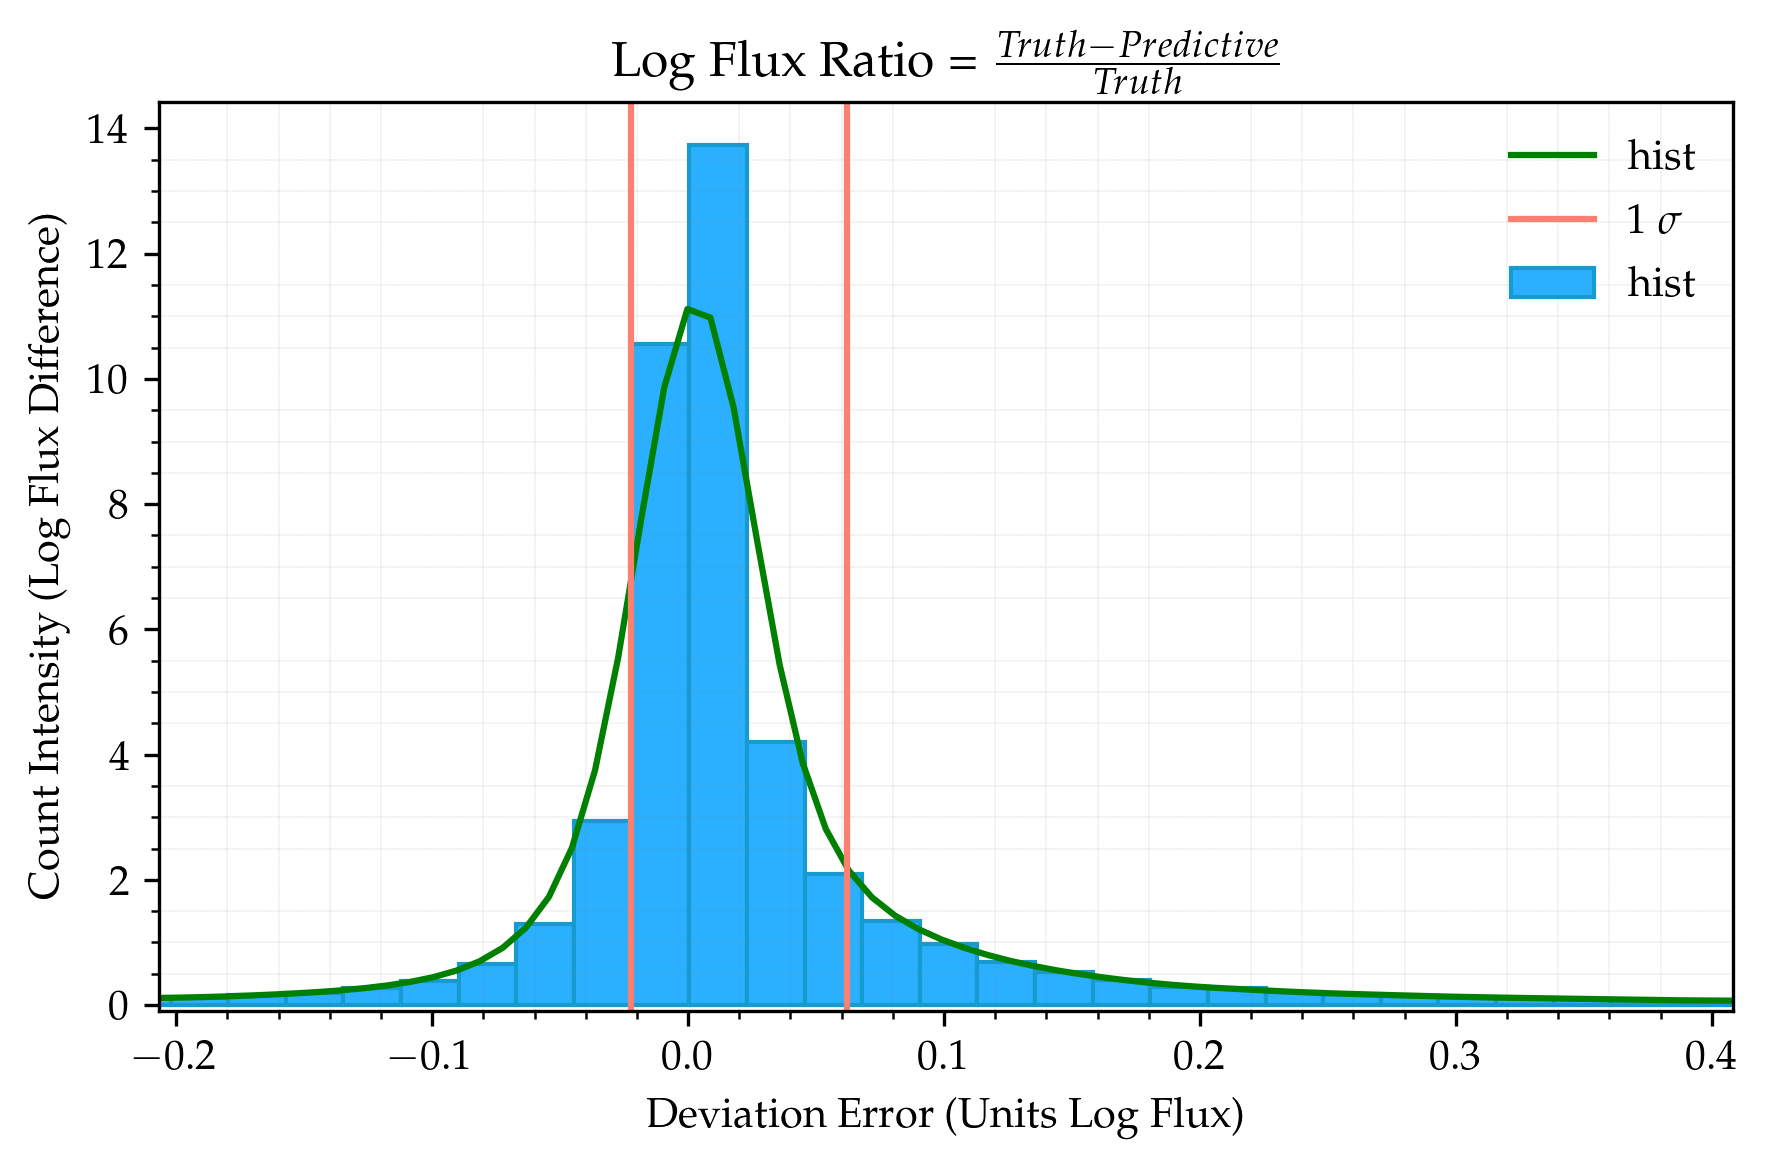

In [5]:
gp.ComputeDifferenceFlux()
gp.plot_difference_histogram(binning = 200)
print("[STATUS] Difference histogram for Leave-One-Out Cross Validation")